In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import re

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')


In [80]:
class consts:
    c = 3e8
    e = 1.6e-19
    m_e = 9.1e-31 # kg
    h = 6.626e-34 # J * s
    hbar = 1.054e-34 # J * s
class setup:
    dummy = 0


### Dynamic

In [81]:
# Из фоток (см. ms_2.51 и тд.)

dyn = {
    'V'     : (2.51,    2.77,    2.97),
    'V_min' : (6.8,     7.1,     6.5),
    'sig_V_min' : (6.8,     7.1,     6.5),
    'V_max' : (2.1,     2.2,     2),
    'sig_V_max' : (2.1,     2.2,     2),
    'V_br'  : (13.1,    12.3,    11.0),
    'sig_V_br' : (13.1,    12.3,    11.0),
}

def get_l_U0(V_max, V_min, V_max_err = 0, V_min_err = 0):
    l = consts.h * np.sqrt(5/32) / np.sqrt(consts.m_e * consts.e * (V_min - V_max)) # лабник формула (10)
    epsilon_diff = np.sqrt(V_max_err**2 + V_min_err**2) / abs(V_max - V_min)
    l_err = l * 0.5 * epsilon_diff
    print(f"l = ({l * 1e10:.1f} +- {l_err * 1e10:.2f}) Angstrem")

    U0 = 4/5 * V_min - 9/5 * V_max
    du0 = math.sqrt((4/5 * V_min_err)**2 + (9/5 * V_max_err)**2)
    print(f"U0 = {U0:.1f}+- {du0:.1f}) eV")

    return l * 1e10, l_err * 1e10, U0, du0

def export_MMM(data, name, dgts=1):

    arr_l = []
    arr_l_err = []
    U0 = []
    dU0 = []

    data2 = pd.DataFrame()

    for i in range(len(data)):
        print("V = {}".format(data["V"][i]))
        __l, __l_err, u0, du0 = get_l_U0(data['V_max'][i], data['V_min'][i], data["sig_V_max"][i], data["sig_V_min"][i])
        print("")

        arr_l.append(__l)
        arr_l_err.append(__l_err)
        U0.append(u0)
        dU0.append(du0)

    data2.insert(0, 'V', data["V"])
    data2.insert(1, 'l', arr_l)
    data2.insert(2, 'dl', arr_l_err)
    data2.insert(3, 'U0', U0)
    data2.insert(4, 'dU0', dU0)

    fmt = {
        ('V') : [r'$V_{накал}, В$', '{:.2f}', 0],
        ('V_min') : [r'$V_{\text{мин}}, В$', '{:.' + str(dgts) + 'f}', 0],
        ('sig_V_min') : [r'$\sigma_{V_{мин}}, В$', '{:.' + str(dgts) + 'f}', 0],
        ('V_max') : [r'$V_{\text{макс}}, В$', '{:.' + str(dgts) + 'f}', 0],
        ('sig_V_max') : [r'$\sigma_{V_{макс}}, В$', '{:.' + str(dgts) + 'f}', 0],
        ('V_br') : [r'$V_{\text{пробой}}, В$', '{:.' + str(dgts) + 'f}', 0],
        ('sig_V_br') : [r'$\sigma_{V_{пробой}}, В$', '{:.' + str(dgts) + 'f}', 0],
        #('l') : [r'$l$, А', '{:.1f}', 0],
        #('dl') : [r'$\sigma_l$, А', '{:.1f}', 0],
    }

    tab = mipt.table(data, fmt)
    tab.to_latex(name + ".tex")

    fmt = {
        ('V') : [r'$V_{накал}, В$', '{:.2f}', 0], # filament Voltage - напряжение накала
        ('l') : [r'$l$, \angstrom', '{:.' + str(dgts) + 'f}', 0],
        ('dl') : [r'$\sigma_l$, \angstrom', '{:.' + str(dgts) + 'f}', 0],
        ('U0') : [r'$U_0$, эВ', '{:.' + str(dgts) + 'f}', 0],
        ('dU0') : [r'$\sigma_{U_0}$, эВ', '{:.' + str(dgts) + 'f}', 0],
    }

    tab = mipt.table(data2, fmt)
    tab.to_latex(name + "-atom.tex")
    return data, tab

error_dig = 0.3 # V
error_eps = 0.04 # 4%

def CalcError(x):
    global error_dig, error_eps
    return np.sqrt(error_dig**2 + (x * error_eps)**2)

dyn_data = pd.DataFrame(dyn)
dyn_data["sig_V_min"] = CalcError(dyn_data["V_min"])
dyn_data["sig_V_max"] = CalcError(dyn_data["V_max"])
dyn_data["sig_V_br"] = CalcError(dyn_data["V_br"])
d, tab = export_MMM(dyn_data, 'gen/tab-dyn')

U_ion = np.average(dyn_data["V_br"])
dU_ion = math.sqrt(np.average(dyn_data['sig_V_br'])**2 + np.std(dyn_data["V_br"]))
print(np.std(dyn_data["V_br"]))
print(f"U_ion = {U_ion:.0f} +- {dU_ion:.0f} V")

V = 2.51
l = (3.2 +- 0.17) Angstrem
U0 = 1.7+- 0.6) eV

V = 2.77
l = (3.1 +- 0.16) Angstrem
U0 = 1.7+- 0.7) eV

V = 2.97
l = (3.2 +- 0.18) Angstrem
U0 = 1.6+- 0.6) eV

0.8653836657164778
U_ion = 12 +- 1 V


### Static

In [82]:
R = 100 # kOm
epsR = 0.1 # 10%

def get_data(filename):
    data = pd.read_excel(filename)
    fmt = {
        'V_ks(V)' : 'V_k',
        'V_a(mV)' : 'V_a',
    }

    data = mipt.map_excel(data, fmt)
    data['I'] = data['V_a'] / 100 # mkA
    return data

data1 = get_data('data/2.52V.xlsx').sort_values(by="V_k")
data2 = get_data('data/2.75V.xlsx').sort_values(by="V_k")

data1

# Для погрешностей используем последнюю цифру разряда. Т.к. там у нас значение скакало

df = data1

def export_df(df, name, costil):
    global epsR
    df.insert(1, 'dV_k', df['V_k'] * 0.0003 + 0.01 + 0.004)
    df.insert(3, 'dV_a', df['V_a'] * 0.0003 + 0.1 + 0.04)
    df.insert(5, 'dI', df["I"] * np.sqrt((epsR)**2 + (df['dV_a'] / df['V_a'])**2))

    keys = [r'$V=2.52$, В', r'$V=2.75$, В']

    df = pd.concat([df], axis='columns', keys=[keys[costil]])

    fmt = {(key, 'V_k')  : [r'$V_{\text{катод}}$, В',  '{:.2f}'] for key in keys} \
        | {(key, 'dV_k') : [r'$\sigma_{V_{\text{катод}}}$, В',  '{:.2f}'] for key in keys} \
        | {(key, 'V_a')  : [r'$V_{\text{анод}}$, мВ',  '{:.1f}'] for key in keys} \
        | {(key, 'dV_a') : [r'$\sigma_{V_{\text{анод}}}$, мВ',  '{:.1f}'] for key in keys} \
        | {(key, 'I')    : [r'$I_{\text{анод}}$, мкА', '{:.3f}'] for key in keys} \
        | {(key, 'dI')   : [r'$\sigma_{I_{\text{анод}}}$, мкА',  '{:.3f}'] for key in keys}


    tab = mipt.table(df, fmt)
    tab.to_latex(name)
    
    
export_df(data1, 'gen/tab-2.52V.tex', costil=0)
export_df(data2, 'gen/tab-2.75V.tex', costil=1)

$V_{накала} = 2.52$ В
V_max = 1.96 +- 0.01463 V, V_min = 7.05 +- 0.016115 V
I_max = 1.15 mkA, I_min = 0.212 mkA
$V_{накала} = 2.75$ В
V_max = 1.9 +- 0.01457 V, V_min = 6.6 +- 0.01598 V
I_max = 1.43 mkA, I_min = 0.52 mkA


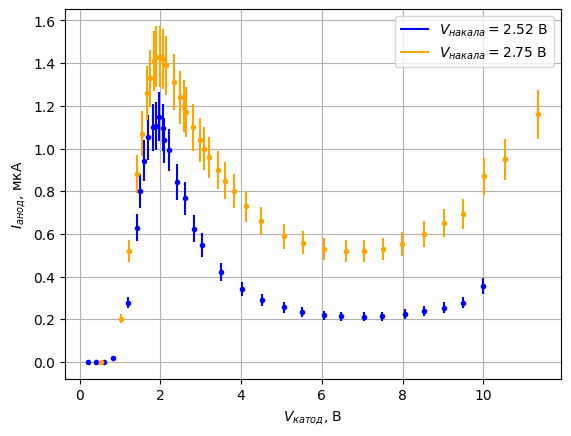

In [83]:
def process(data, label, color, drawmax=False, drawmin=False):
    print(label)
    x = np.array(data['V_k']) # V
    dx = data["dV_k"]
    y = np.array(data['I'])   # mkA
    mipt.plot(x, y, func=None,xerr= data["dV_k"], yerr=data["dI"],label=label, color=color)
    
    maxV = np.argmax(y[:len(y)//2])
    minV = np.argmin(y[len(y)//2:]) + len(y)//2
    if drawmax: plt.axvline(x[maxV], linestyle=':', c=color)
    if drawmin: plt.axvline(x[minV], linestyle=':', c=color)

    print(f"V_max = {x[maxV]} +- {dx[maxV]} V, V_min = {x[minV]} +- {dx[minV]} V")
    print(f"I_max = {y[maxV]} mkA, I_min = {y[minV]} mkA")

    return x[maxV], x[minV]

V_max, V_min = process(data1, "$V_{накала} = 2.52$ В", 'blue')
#V_max_err = 0.1
#V_min_err = 0.2
#l, U0 = get_l_U0(V_max, V_min, V_max_err, V_min_err)

process(data2, "$V_{накала} = 2.75$ В", 'orange', drawmin=False)

plt.xlabel(r'$V_{катод}$, В')
plt.ylabel(r'$I_{анод}$, мкА')
plt.legend()
plt.grid()
plt.savefig('gen/static.pdf')


In [84]:
st = {
    'V' :     (2.52,    2.75),
    'V_min' : (7.05,    6.60),
    'sig_V_min' : (0.02,     0.02),
    'V_max' : (1.96,     1.90),
    'sig_V_max' : (0.02,    0.02),
    #'V_br'  : (10,      11),
}

error = 1 #В
st_data = pd.DataFrame(st)
d, tab = export_MMM(st_data, 'gen/tab-st', 2)

V = 2.52
l = (3.0 +- 0.01) Angstrem
U0 = 2.1+- 0.0) eV

V = 2.75
l = (3.2 +- 0.01) Angstrem
U0 = 1.9+- 0.0) eV



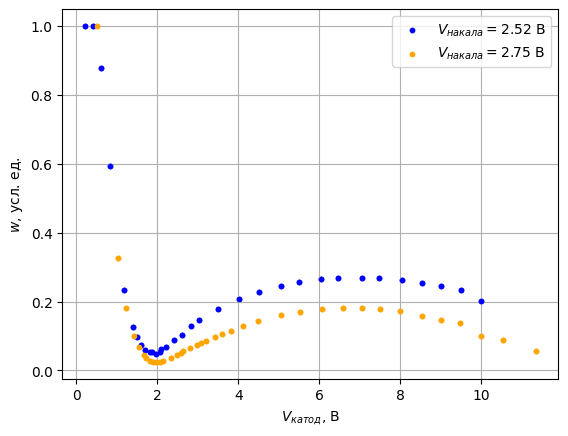

In [85]:
def probability(data, label, color, start, end=None):
    x = np.array(data['V_k'])
    y = np.array(data['I'])
    if end == None: end = len(x)
    x = np.array(x[start:end])    # V
    y = -np.log(0.6 * y[start:end]) # Этот 0.6 вообще никакого смысла не имеет (это я выбрал I_0). 
                                    # Просто, чтобы не проходило через отрицательные значения
    y = y / max(y)

    mipt.plot(x, y, func=None, color=color)
    plt.scatter(x, y, label=label, c = color, s=10)
    return None

probability(data1, "$V_{накала} = 2.52$ В", 'blue', start=0)
probability(data2, "$V_{накала} = 2.75$ В", 'orange', start=0)
plt.legend()
plt.grid()
plt.xlabel(r'$V_{катод}$, В')
plt.ylabel(r'$w$, усл. ед.')
plt.savefig(f'gen/probability.pdf')
plt.show()
